# Пример простого импорта и запуска расчета c python API

Хабибуллин Ринат

версия 0.1 от 30.09.2021

***
Пример показывает как можно подключиться к `python API` для `Unifloc VBA` и сделать простой расчет.

Основной трюк этого примера - как разобраться с путями на которых находится `Unifloc VBA` и на которых находится python скрипт, который будет считать. Это обеспечить загрузку пакета с модулями импорта.

Работать будет только под windows так как расчеты проводит в итоге Excel

$$Q=\frac{2 \pi kh}{\mu B}$$

In [1]:
"""
Пример автоматического определения путей для примера поставляемого с Unifloc VBA
работает, только если расчетный файл находится во вложенной папке относительно надстройки.
Для других вариантов расположения расчетного файла - ссылки на папки надо модифицировать
""" 

import os
import sys
import inspect

current_path = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
print('Текущая папка где находится скрипт python -- '+ current_path)

# все примеры находятся во вложенной папке репозитория Unifloc VBA 
# поэтому здесь определяется путь к папке репозитория Unifloc VBA 
# если надо - подмените путь здесь на свой
unifloc_path = os.path.dirname(current_path)
print('Путь к папке Unifloc VBA -- '+ unifloc_path)

unifloc_xlam = unifloc_path +'\\UniflocVBA_7.xlam'
print('Путь к надстройке Unifloc VBA -- '+ unifloc_xlam)

# добавим в путь поиска пакетов python папку где находится репозиторий Unifloc VBA
sys.path.insert(0, unifloc_path) 
# импортируем python_api для Unifloc VBA
import unifloc_vba_python_api.python_api as unifloc
# создаем объект имеющий доступ к расчетам Unifloc VBA
unf = unifloc.API(unifloc_xlam)

Текущая папка где находится скрипт python -- C:\unifloc\unifloc_vba\examples_python
Путь к папке Unifloc VBA -- C:\unifloc\unifloc_vba
Путь к надстройке Unifloc VBA -- C:\unifloc\unifloc_vba\UniflocVBA_7.xlam


In [2]:
# импортируем дополнительные библиотеки
import matplotlib.pyplot as plt
import numpy as np

## Задаем параметры флюида и формируем json строку кодирующую параметры флюида

Подсказку по аргументам функций unifloc VBA можно получить используя функцию `help`или можно посмотреть непосредственно в коде. Ниже приведен пример. Обратите внимание, python чувствителен к регистру, поэтому надо в описании смотреть на строку задания функции где перечислены все аргументы с заданными значениями по умолчанию. В развернутом описании аргументов регистр может отличаться.

In [3]:
help(unf.encode_PVT)

Help on method encode_PVT in module unifloc_vba_python_api.python_api:

encode_PVT(gamma_gas=0.6, gamma_oil=0.86, gamma_wat=1, rsb_m3m3=100, pb_atma=0, t_res_C=80, bob_m3m3=0, muob_cP=0, PVT_corr_set=0) method of unifloc_vba_python_api.python_api.API instance
    ========== description ============== 
    Функция кодирования параметров PVT в строку,  для передачи PVT свойств в прикладные функции Унифлок. 
           
    ==========  arguments  ============== 
    
        gamma_gas - удельная плотность газа, по воздуху.  по умолчанию const_gg_ = 0.6    
    
        gamma_oil - удельная плотность нефти, по воде.  по умолчанию const_go_ = 0.86    
    
        gamma_wat - удельная плотность воды, по воде.  по умолчанию const_gw_ = 1    
    
        rsb_m3m3 - газосодержание при давлении насыщения, м3/м3.  по умолчанию const_rsb_default = 100    
    
        pb_atma - давление насыщения при заданной температуре, атма.  опциональный калибровочный параметр,  если не задан или = 0, то рас

In [3]:
# задаем флюид задавая все параметры.
# для наглядности используем имена аргументов для задания значений
fluid = unf.encode_PVT(gamma_gas=0.8, 
                       gamma_oil=0.82, 
                       gamma_wat=1.1, 
                       rsb_m3m3=120, 
                       pb_atma=150, 
                       t_res_C=80, 
                       bob_m3m3=1.2, 
                       muob_cP=0.5, 
                       PVT_corr_set=0)
# выведем итоговую json строку
print(fluid)

{"gamma_gas":0.8,"gamma_oil":0.82,"gamma_wat":1.1,"rsb_m3m3":120,"pb_atma":150,"t_res_C":80,"bob_m3m3":1.2,"muob_cP":0.5,"PVT_corr_set":0}


## Расчет газосодержания в нефти

Для примера рассчитаем значение газосодержания $r_s$ в заданной нефти и построим график зависимости газосодержания от давления

In [4]:
help(unf.PVT_rs_m3m3)

Help on method PVT_rs_m3m3 in module unifloc_vba_python_api.python_api:

PVT_rs_m3m3(p_atma, t_C, PVT_prop) method of unifloc_vba_python_api.python_api.API instance
    ========== description ============== 
    расчет газосодержания 
           
    ==========  arguments  ============== 
    
        p_atma - давление, атм    
    
        t_c - температура, с.    
    
        pvt_prop - строка с параметрами флюида,  используйте encode_pvt для ее генерации



In [5]:
# пример расчета газосодерждания при давлении 1 атм, и температуре 80 C
rs = unf.PVT_rs_m3m3(1, 80, fluid)
print(rs)

0.28612023857689795


In [6]:
# удобнее для чтения кода при вызове функций указывать названия аргументов
rs = unf.PVT_rs_m3m3(p_atma=1, t_C=80, PVT_prop=fluid)
print(rs)

0.28612023857689795


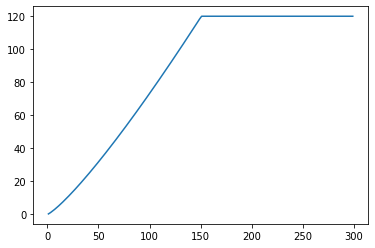

In [7]:
# для отрисовки графика сформируем массив давлений и рассчитаем для него значения газосодержания
plist = np.arange(1,300,2)
rslist = np.array([unf.PVT_rs_m3m3(p_atma=pi, t_C=80, PVT_prop=fluid) for pi in plist])

plt.plot(plist, rslist)
plt.show()

В Unifloc VAB python API генерируются функции не поддерживающие векторные расчеты numpy. В некоторых случаях для повышения наглядности расчетного кода необходимые функции можно векторизовать самостоятельно. Пример приведен ниже

In [9]:
# векторизуем функцию расчета газосодержания
rs_m3m3 = np.vectorize(unf.PVT_rs_m3m3)

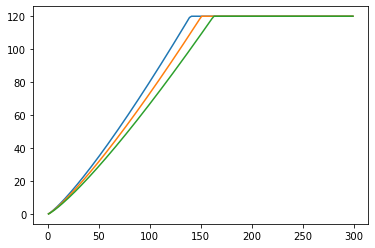

In [10]:
# для отрисовки графика сформируем массив давлений и рассчитаем для него значения газосодержания
plist = np.arange(1,300,2)

rslist = rs_m3m3(p_atma=plist, t_C=60, PVT_prop=fluid) 
plt.plot(plist, rslist)

rslist = rs_m3m3(p_atma=plist, t_C=80, PVT_prop=fluid) 
plt.plot(plist, rslist)

rslist = rs_m3m3(p_atma=plist, t_C=100, PVT_prop=fluid) 
plt.plot(plist, rslist)

plt.show()

Графики можно укасить, добавить подписи и легенду. Оставим это читателю в качестве упражнения